In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import random
%matplotlib inline
import cv2

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
def get_measure_note(thickness = 3, height = 45, width = 10):
    measure_note = np.zeros([height,width])
    length = random.randint(height-3,height)
    measure_note[0:length, int(width/2):int(width/2)+thickness] = 255
    rows,cols = measure_note.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-5,5),random.random()*0.12 + 0.95)
    measure_note = cv2.warpAffine(measure_note,M,(cols,rows))
    measure_note = cv2.GaussianBlur(measure_note,(3,3),0)
    return measure_note

In [4]:
def get_rest_bar(thickness = 3, height = 45, width = 10):
    rest_bar = np.zeros([height,width])
    length = random.randint(43,45)
    rest_bar[int(height/2)-1:int(height/2)+thickness-1, 0:10 - random.randint(0,2)] = 255
    rows,cols = rest_bar.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-4,10),random.random()*0.12 + 0.95)
    rest_bar = cv2.warpAffine(rest_bar,M,(cols,rows))
    rest_bar = cv2.GaussianBlur(rest_bar,(3,3),0)
    return rest_bar

In [6]:
def get_note(last_digit = -1, can_zero=True):
    canvass = np.zeros([45,28])
    index = random.randint(0,x_train.shape[0])
    while y_train[index] > 7 or y_train[index] == last_digit or (not can_zero and y_train[index] == 0):
        index = random.randint(0,x_train.shape[0])
    canvass[4:32,:] = x_train[index]
    label = y_train[index]
    level_vote = random.randint(0,2)
    if level_vote == 0 or label == 0:
        return canvass, label
    
    if level_vote == 1:
        canvass[0:3,12:15] = 255
        canvass[0:5,11:16] = cv2.GaussianBlur(canvass[0:5,11:16],(3,3),0)
        return canvass, label + 10
    
    if level_vote == 2:
        canvass[41:44,12:15] = 255
        canvass[40:44,11:16] = cv2.GaussianBlur(canvass[40:44,11:16],(3,3),0)
        return canvass, label + 20

In [12]:
def get_combination(last_digit, simple_version = False):
    #1 * 1/4, 2 * 1/8, 1 * 1/8 + 2 * 1/16,  2 * 1/16 + 1/8, 4 * 1/16 
    index = random.randint(1,5)
    index = 1
    if simple_version:
        index = True
    if index == 1:
        # 1 * 1/4
        seed = random.randint(1,2)
        if seed == 1 and not simple_version and last_digit != -1 and last_digit != 0:
            c = get_rest_bar()
            return c, ['-'], last_digit
        c, label =  get_note(last_digit=last_digit)
        return c, [str(label) + "_4"], [[0,0,c.shape[0]-1, c.shape[1]-1]], label
    if index == 2:
        # 2 * 1/8
        img1, label1 = get_note(last_digit=last_digit)
        img2, label2 = get_note(label1)
        c = np.hstack((img1, img2))
        c[34:36, 5:55] = 255
        rows = 3
        cols = 51
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-4,4),random.random()*0.12 + 0.95)
        c[34:37, 4:55] = cv2.warpAffine(c[34:37, 4:55],M,(cols,rows))
        return c, [str(label1) + '_8',str(label2) + '_8'], [[0,0, 44, img1.shape(1) - 1], [0, img1.shape(1), 44, c.shape(1)-1]],  label2
        
    if index == 3:
        #2 * 1/16 + 1/8
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        c = np.hstack((img1, img2, img3))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 5:52] = 255
        rows = 8
        cols = c.shape[1] - 9
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(1,3),1)
        c[32:40, 4:c.shape[1]-5] = cv2.warpAffine(c[32:40, 4:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_16',str(label2) + '_16', str(label3) + '_8'], label3
    
    if index == 4:
        #1/8 + 2 * 1/16
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        c = np.hstack((img1, img2, img3))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 35:c.shape[1]-5] = 255
        rows = 8
        cols = c.shape[1] - 9
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(1,3),1)
        c[32:40, 4:c.shape[1]-5] = cv2.warpAffine(c[32:40, 4:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_8',str(label2) + '_16', str(label3) + '_16'], label3
    if index == 5:
        #4 * 1/16
        pass
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        [img4, label4] = get_note(label3)
        c = np.hstack((img1, img2, img3, img4))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 5:c.shape[1]-5] = 255
        rows = 8
        cols = 102
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-1,1),1)
        c[31:39, 5:c.shape[1]-5] = cv2.warpAffine(c[32:39, 5:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_16',str(label2) + '_16', str(label3) + '_16', str(label4) + '_16'], label4

In [61]:
def get_box(canvass, show_graph = True, base_coord=[0,0,0,0]):
    top_boundary = 0
    bottom_boundary = canvass.shape[0]-1
    left_boundary = 0
    right_boundary = canvass.shape[1]-1
    for i in range(canvass.shape[1]):
        for j in range(canvass.shape[0]):
            if canvass[j][i]:
                right_boundary = i
                break
                
    for i in reversed(range(canvass.shape[1])):
        for j in range(canvass.shape[0]):
            if canvass[j][i]:
                left_boundary = i
                break
    print(top_boundary, bottom_boundary, left_boundary, right_boundary)
    canvass[top_boundary:bottom_boundary,left_boundary:left_boundary+1] = 255
    canvass[top_boundary:bottom_boundary,right_boundary-1:right_boundary] = 255
    canvass[top_boundary:top_boundary+1,left_boundary:right_boundary] = 255
    canvass[bottom_boundary-1:bottom_boundary,left_boundary:right_boundary] = 255
    if show_graph:
        plt.imshow(canvass)
    return [top_boundary + base_coord[0], left_boundary + base_coord[1], bottom_boundary + base_coord[2], right_boundary ++ base_coord[3]]

0 44 4 23


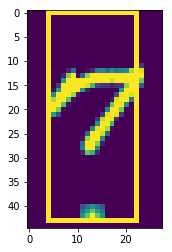

In [62]:
[c, labels, loc, last_digit] = get_combination(-1)
draw_box(c)

In [1358]:
def get_line(max_width, measure_capacity = 2, simple_version = False, try_num = 3):
    canvass, labels, last_digit = get_combination(-1, simple_version=simple_version)
    curr_width = canvass.shape[1]
    remained_measure = measure_capacity - 1
    while True:
        new_canvasses, new_labels, last_digit = get_combination(last_digit, simple_version=simple_version)
        remained_measure = measure_capacity - 1
        while remained_measure:
            new_canvass, new_label, last_digit = get_combination(last_digit, simple_version=simple_version)
            new_canvasses = np.hstack((new_canvasses, new_canvass))
            new_labels += new_label
            remained_measure -= 1
        
        new_measure_note = get_measure_note()
        new_canvasses = np.hstack((new_canvasses, new_measure_note))
        new_labels += '|'
        if new_canvasses.shape[1] + canvass.shape[1] > max_width:
            if try_num == 0:
                break
            try_num -=1
            continue
        canvass = np.hstack((canvass, new_canvasses))
        labels += new_labels
        curr_width += new_canvass.shape[1]
    canvass = np.hstack((canvass, np.zeros([45, max_width - canvass.shape[1]])))
    return canvass, labels

In [1359]:
def get_page(directory, max_height, max_width, measure_capacity, inner_line_spacing = 30, simple_version = False):
    canvass, labels = get_line(max_width, measure_capacity, simple_version)
    curr_height = canvass.shape[0]
    while curr_height < max_height:
        new_canvass1 = np.zeros([inner_line_spacing, max_width])
        new_canvass2, new_labels = get_line(max_width, measure_capacity, simple_version)
        new_canvass = np.vstack((new_canvass1, new_canvass2))
        if curr_height + new_canvass.shape[0] > max_height:
            break
        canvass = np.vstack((canvass, new_canvass))
        labels += new_labels
        curr_height += new_canvass.shape[0]
    cv2.imwrite(directory, canvass)
    return canvass, labels

['2_8', '3_16', '21_16', '3_16', '24_16', '17_16', '17_16', '21_4', '|', '-', '4_8', '26_16', '22_16', '|', '-', '11_16', '6_16', '0_8', '|', '12_8', '1_16', '0_16', '6_8', '27_8', '|', '22_8', '21_16', '0_16', '3_4', '1_8', '0_8', '|', '2_8', '17_8', '27_16', '6_16', '12_16', '21_16', '|', '-', '21_16', '0_16', '4_8', '|', '23_8', '0_8', '23_8', '1_8', '|', '26_8', '1_16', '14_16', '0_16', '25_16', '23_16', '14_16', '21_8', '17_16', '0_16', '|', '6_16', '0_16', '21_8', '26_8', '5_16', '0_16', '|', '7_16', '24_16', '24_8', '4_16', '16_16', '0_16', '11_16', '5_8', '13_8', '|', '0_8', '26_8', '17_8', '2_16', '23_16', '|', '22_4', '3_8', '26_16', '2_16', '|', '13_4', '21_4', '|', '11_16', '15_16', '27_16', '6_16', '22_4', '3_16', '4_16', '5_8', '|', '11_8', '4_16', '12_16', '22_8', '21_16', '5_16', '|', '3_16', '6_16', '0_8', '15_8', '11_16', '21_16', '|', '25_8', '7_16', '16_16', '23_16', '13_16', '12_8', '11_16', '23_16', '4_8', '|', '7_8', '2_8', '26_8', '0_8', '|', '14_8', '26_16', '1

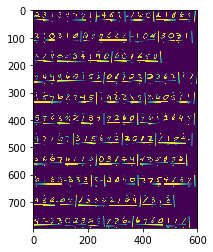

In [1360]:
[c, labels] = get_page('./output.png',800,600,2, simple_version=False)
print(labels)
plt.imshow(c)

[10, 46, 221, 249]


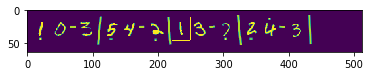

In [507]:
draw_box(canvas,note_box[10])